# Notebook configuration

In [70]:
import glob

run_number    = 4482
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/pmaps*.root.h5".format(run_number))

# Dorothea cut analysis

In [71]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import labels

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units_c import units

Running on  Fri Jul 14 17:44:00 2017


#### General plotting options

In [72]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

#### Function to select number of peaks

In [73]:
def select_peaks(select, s1_all, s2_all, s2si_all):
    nevt_out = 0
    s1_cut = {}
    s2_cut = {}
    s2si_cut = {}
    for evt in s1_all:
        if not s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]):
            continue
        s2_cut_dummy, s2si_cut_dummy = select.select_S2(s2_all[evt], s2si_all[evt])
        s1_cut[evt] = select.select_S1(s1_all[evt])
        s2_cut[evt] = s2_cut_dummy
        s2si_cut[evt] = s2si_cut_dummy
        nevt_out += 1
    return nevt_out, s1_cut, s2_cut, s2si_cut

In [74]:
def select_peaks_dist(select, s1_all, s2_all, s2si_all):
    nevt_out = 0
    s1_cut = {}
    s2_cut = {}
    s2si_cut = {}
    
    s1n = []
    s1w = []
    s1h = []
    s1e = []

    s2n = []
    s2w = []
    s2h = []
    s2ec = []
    s2ea = []
    s2nsipm = []
    
    for evt in s1_all:
        if not s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]):
            continue
        s2_cut_dummy, s2si_cut_dummy = select.select_S2(s2_all[evt], s2si_all[evt])
        s1_cut[evt] = select.select_S1(s1_all[evt])
        s2_cut[evt] = s2_cut_dummy
        s2si_cut[evt] = s2si_cut_dummy

        s1n.append(len(s1_cut[evt]))
        for no,peak in s1_cut[evt].items():
            s1w.append(np.size(peak[1]))
            s1h.append(np.max(peak[1]))
            s1e.append(np.sum(peak[1]))
        
        s2n.append(len(s2_cut[evt]))
        for no, peak in s2_cut[evt].items():
            s2w.append(np.size(peak[1]))
            s2h.append(np.max(peak[1]))
            s2ec.append(np.sum(peak[1]))
        for no, peak in s2si_cut[evt].items():
            s2nsipm.append(len(peak))
            s2ea.append(np.sum(list(peak.values())))
            
        nevt_out += 1
        
    return nevt_out, s1_cut, s2_cut, s2si_cut, np.array(s1n), np.array(s1w), np.array(s1h), np.array(s1e), \
            np.array(s2n), np.array(s2w), np.array(s2h), np.array(s2ec), np.array(s2ea), np.array(s2nsipm)

In [75]:
def plot_var(s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm):
    hist(s1n, 10, [-0.5, 9.5]);
    labels("Number", "Entries", "S1 number")
    
    hist(s1w, (np.max(s1w) - np.min(s1w) + 2), [np.min(s1w)-1, np.max(s1w)]);
    labels("$\mu$s", "Entries", "S1 width")

    hist(s1e, 100, [np.min(s1e), np.max(s1e)]);
    labels("pes", "Entries", "S1 energy")

    hist(s1h, 100, [np.min(s1h), np.max(s1h)]);
    labels("pes", "Entries", "S1 height")

    hist(s2n, 10, [-0.5, 9.5]);
    labels("Number", "Entries", "S2 number")

    hist(s2w, (np.max(s2w) - np.min(s2w) + 2), [np.min(s2w)-1, np.max(s2w)]);
    labels("$\mu$s", "Entries", "S2 width")

    hist(s2ec, 100, [np.min(s2ec), np.max(s2ec)]);
    labels("pes", "Entries", "S2 cathode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])

    hist(s2ea, 100, [np.min(s2ea), np.max(s2ea)]);
    labels("pes", "Entries", "S2 anode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])

    hist(s2h, 100, [np.min(s2h), np.max(s2h)]);
    labels("pes", "Entries", "S2 height")

    hist(s2nsipm, 1793, [-0.5, 1792.5])
    labels("Number", "Entries", "SiPM number")

    hist2d(s1n, s2n, 10, [[-0.5, 9.5], [-0.5, 9.5]])
    labels("Number S1", "Number S2", "Nº S1 vs Nº S2")

# Read data

In [76]:
s1_all = {}
s2_all = {}
s2si_all = {}

n_s1 = 0
n_s2 = 0
n_s2si = 0
n_common = 0
n_some = 0
n_function = 0

for file in inputfiles[:50]:
    s1_file, s2_file, s2si_file = pmapsf.load_pmaps(file)
    n_s1 += len(s1_file)
    n_s2 += len(s2_file)
    n_s2si += len(s2si_file)
    someS12_events = set(s1_file.keys()) | set(s2_file.keys()) | set(s2si_file.keys())
    common_events = set(s1_file.keys()) & set(s2_file.keys()) & set(s2si_file.keys())
    n_some += len(someS12_events)
    n_common += len(common_events)
    n_function += len(get_event_numbers_and_timestamps_from_file_name(file)[0])
    s1_all.update({k:v for k,v in s1_file.items() if k in common_events})
    s2_all.update({k:v for k,v in s2_file.items() if k in common_events})
    s2si_all.update({k:v for k,v in s2si_file.items() if k in common_events})

In [77]:
print("Events with S1: {}".format(n_s1))
print("Events with S2: {}".format(n_s2))
print("Events with S2si: {}".format(n_s2si))
print("Events with all: {}".format(n_common))
print("Events with any: {}".format(n_some))
print("Events from file: {}".format(n_function))

Events with S1: 2209
Events with S2: 2014
Events with S2si: 1982
Events with all: 1940
Events with any: 2252
Events from file: 2326


#### Base selector with Dorothea cut parameters

In [ ]:
def selector_conf():
    return dict(s1_nmin     =   1  , s1_nmax     = 1    ,
                s1_emin     =   2  , s1_emax     = 10   ,
                s1_wmin     =  10  , s1_wmax     = 100  ,
                s1_hmin     =   0.4, s1_hmax     = 10   ,
                s1_ethr     =   0.1,
                s2_nmin     =   1  , s2_nmax     = 2    ,
                s2_emin     = 500  , s2_emax     = 50000,
                s2_wmin     = 200  , s2_wmax     = 1000 ,
                s2_hmin     = 100  , s2_hmax     = 1000 ,
                s2_nsipmmin =   1  , s2_nsipmmax = 10   ,
                s2_ethr     =   2  )

In [78]:
s1_emin = 100.
s1_emax = 1000.
s1_wmin = 8
s1_wmax = 30
s1_hmin = 40.
s1_hmax = 300.
s1_num = 1
s1_ethr = 0.

s2_emin = 2000.
s2_emax = 10000000.
s2_wmin = 5.
s2_wmax = 1000.
s2_hmin = 1.
s2_hmax = 100000.
s2_numMin = 1
s2_numMax = 10
s2_ethr = 2.
s2_nsipmmin = 1
s2_nsipmmax = 1800

def refresh_selector():
    s1_emin = 100.
    s1_emax = 1000.
    s1_wmin = 8
    s1_wmax = 30
    s1_hmin = 40.
    s1_hmax = 300.
    s1_num = 1
    s1_ethr = 0.

    s2_emin = 2000.
    s2_emax = 10000000.
    s2_wmin = 5.
    s2_wmax = 1000.
    s2_hmin = 1.
    s2_hmax = 100000.
    s2_numMin = 1
    s2_numMax = 10a
    s2_ethr = 2.
    s2_nsipmmin = 1
    s2_nsipmmax = 1800

    selector = s1s2filt.S12Selector(s1_nmin = s1_num, s1_nmax = s1_num, s1_emin = s1_emin, s1_emax = s1_emax, s1_ethr = s1_ethr,
                                    s1_lmin = s1_wmin, s1_lmax = s1_wmax, s1_hmin = s1_hmin, s1_hmax = s1_hmax,
                                    s2_nmin = s2_numMin, s2_nmax = s2_numMax, s2_emin = s2_emin, s2_emax = s2_emax, 
                                    s2_lmin = s2_wmin, s2_lmax = s2_wmax, s2_hmin = s2_hmin, s2_hmax = s2_hmax, 
                                    s2_nsipmmin = s2_nsipmmin, s2_nsipmmax = s2_nsipmmax, s2_ethr = s2_ethr)

    return selector

# Cut studies

### Variable distribution

In [79]:
selector = s1s2filt.S12Selector(s1_nmin = -1, s1_nmax = 1e10, s1_emin = -1, s1_emax = 1e10, s1_ethr = -1,
                                s1_lmin = -1, s1_lmax = 1e10, s1_hmin = -1, s1_hmax = 1e10,
                                s2_nmin = -1, s2_nmax = 1e10, s2_emin = -1, s2_emax = 1e10, 
                                s2_lmin = -1, s2_lmax = 1e10, s2_hmin = -1, s2_hmax = 1e10, 
                                s2_nsipmmin = -1, s2_nsipmmax = 1e10, s2_ethr = -1)

In [80]:
n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)

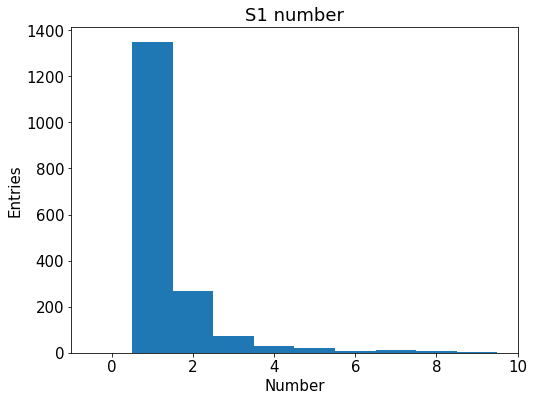

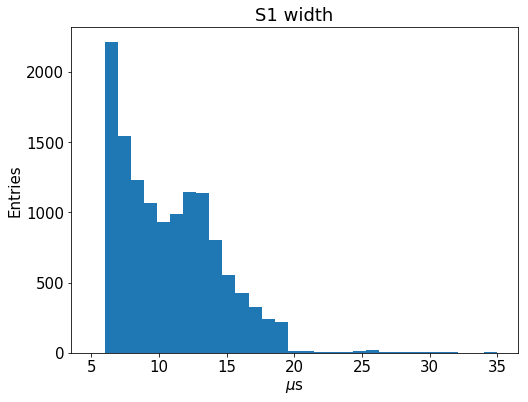

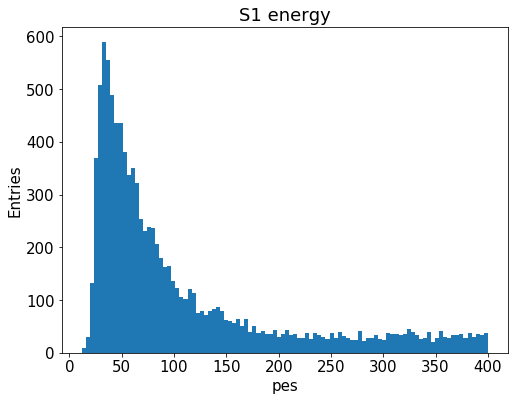

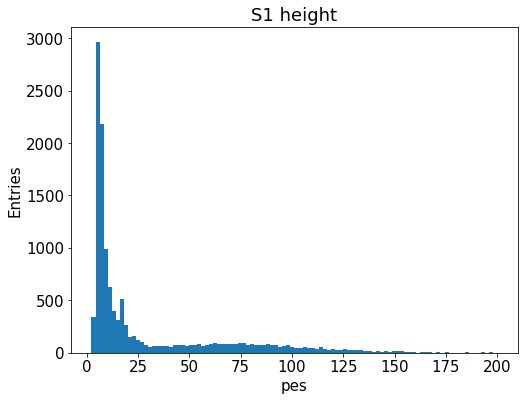

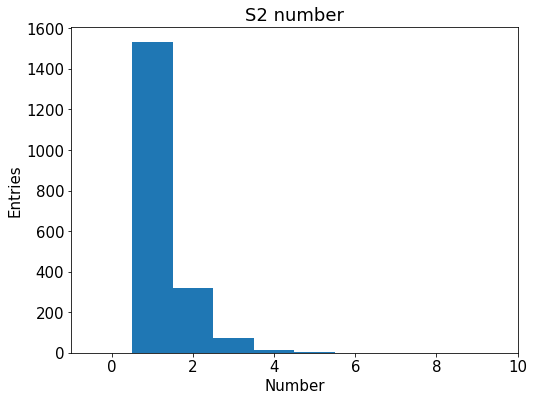

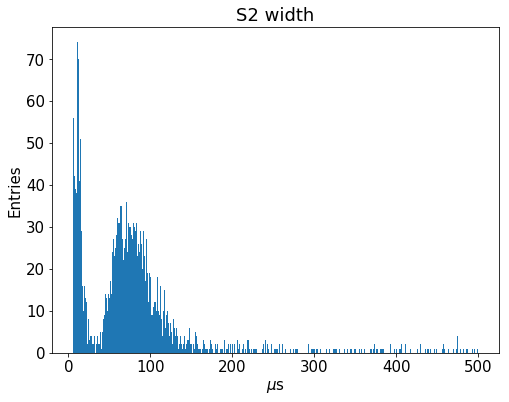

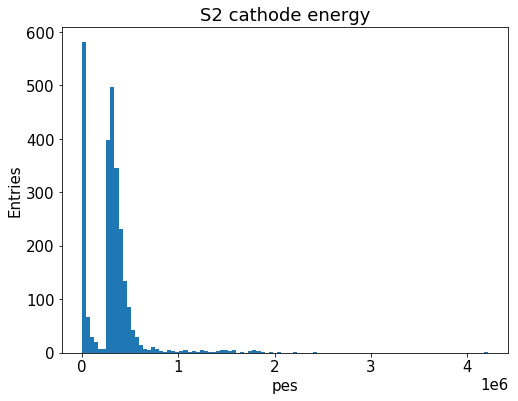

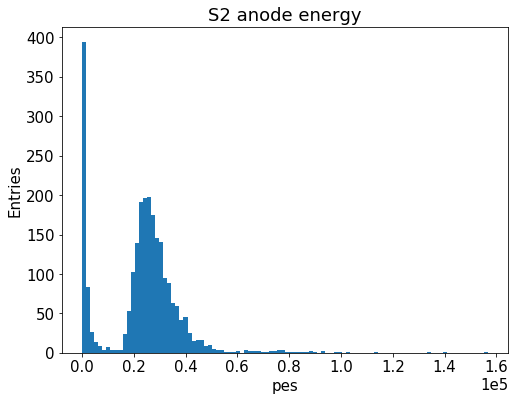

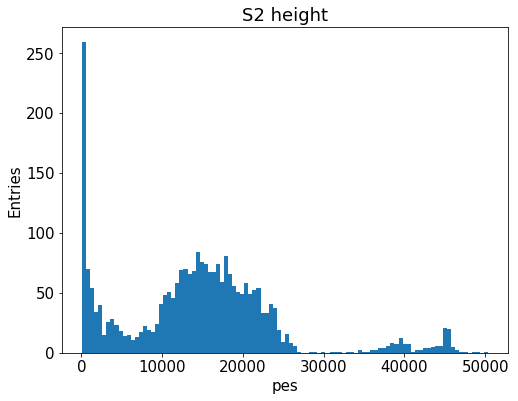

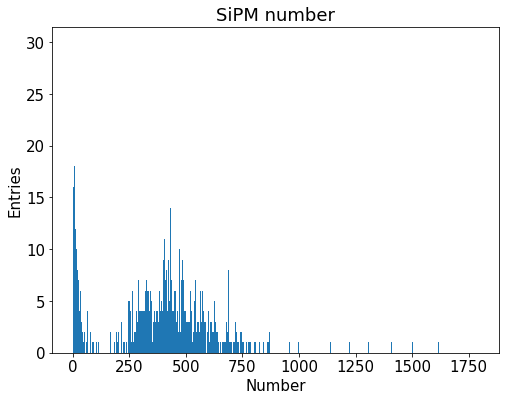

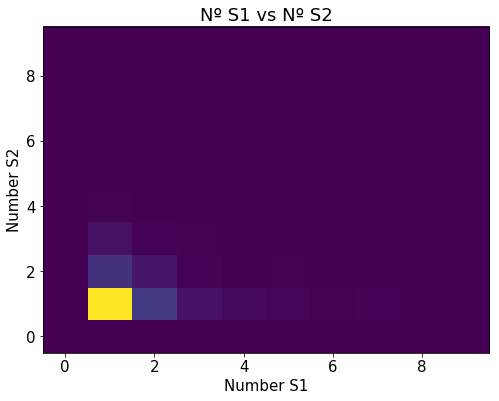

In [81]:
plot_var(s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm)

#### Variable to save maximum values

In [82]:
max_val = {}

## S1 cuts

### S1 min width

Maximum efficiency of 0.8829896907216495 at 9


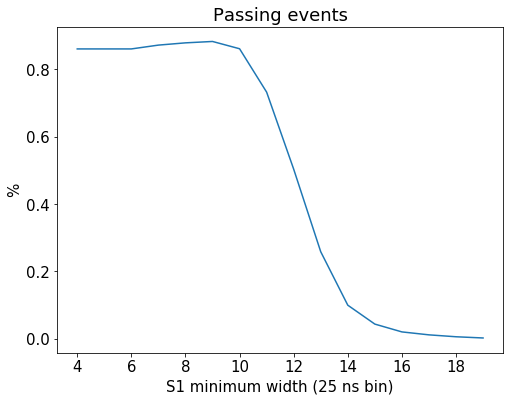

In [83]:
selector = refresh_selector()
var_min = 4
var_max = 20
step = 1
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Lmin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")



max_val["s1_wmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max width

Maximum efficiency of 0.8809278350515464 at 18


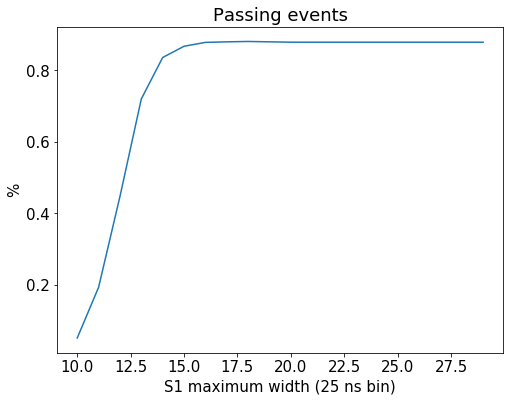

In [84]:
selector = refresh_selector()
var_min = 10
var_max = 30
step = 1
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Lmax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_wmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 min E

Maximum efficiency of 0.8788659793814433 at 0


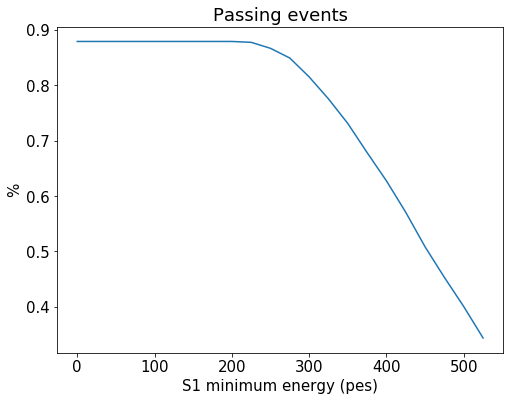

In [85]:
selector = refresh_selector()
var_min = 0
var_max = 550
step = 25
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Emin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_emin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max E

Maximum efficiency of 0.8793814432989691 at 900


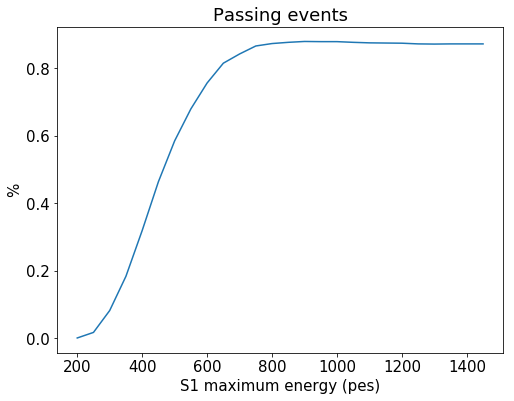

In [86]:
selector = refresh_selector()
var_min = 200
var_max = 1500
step = 50
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Emax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_emax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 min H

Maximum efficiency of 0.8798969072164948 at 42.0


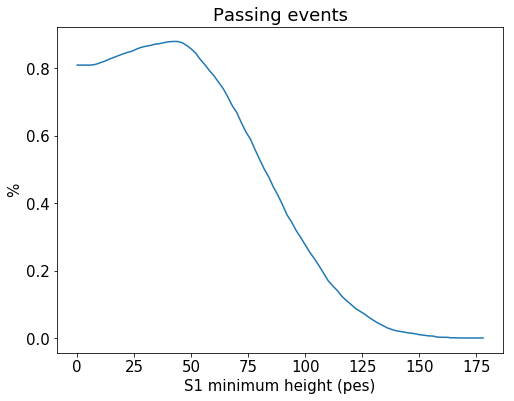

In [87]:
selector = refresh_selector()
var_min = 0.
var_max = 180.
step = 2.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Hmin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_hmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max H

Maximum efficiency of 0.8793814432989691 at 165.0


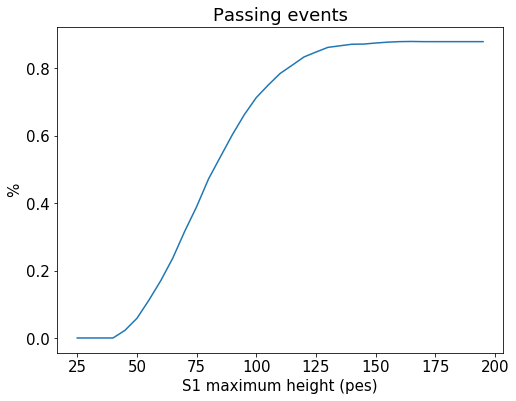

In [88]:
selector = refresh_selector()
var_min = 25.
var_max = 200.
step = 5.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Hmax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_hmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 E thr

Maximum efficiency of 0.8788659793814433 at 0.0


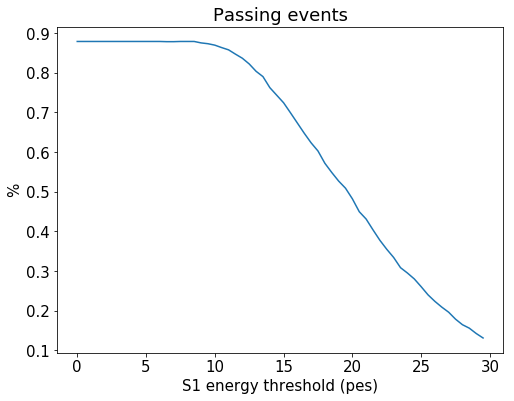

In [89]:
var_min = 0.
var_max = 30.
step = 0.5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = max_val["s1_emin"], s1_emax = max_val["s1_emax"], 
                                s1_ethr = 0., s1_lmin = max_val["s1_wmin"], s1_lmax = max_val["s1_wmax"], 
                                s1_hmin = max_val["s1_hmin"], s1_hmax = max_val["s1_hmax"],
                                s2_nmin = s2_numMin, s2_nmax = s2_numMax, s2_emin = s2_emin, s2_emax = s2_emax, 
                                s2_lmin = s2_wmin, s2_lmax = s2_wmax, s2_hmin = s2_hmin, s2_hmax = s2_hmax, 
                                s2_nsipmmin = s2_nsipmmin, s2_nsipmmax = s2_nsipmmax, s2_ethr = s2_ethr)

for w in var:
    selector.S1_Ethr = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 energy threshold (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_ethr"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### Efficiency with S1 max args

S1 max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0}
Efficiency with S1 max args: 0.8855670103092783


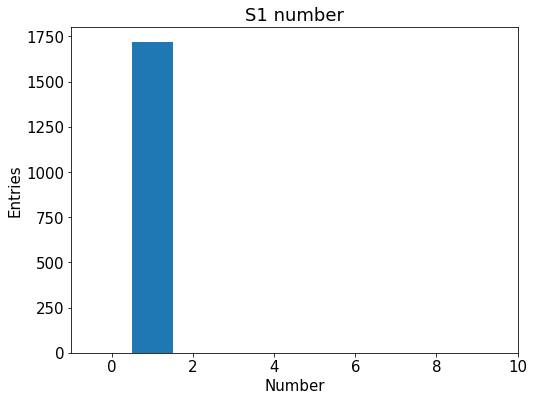

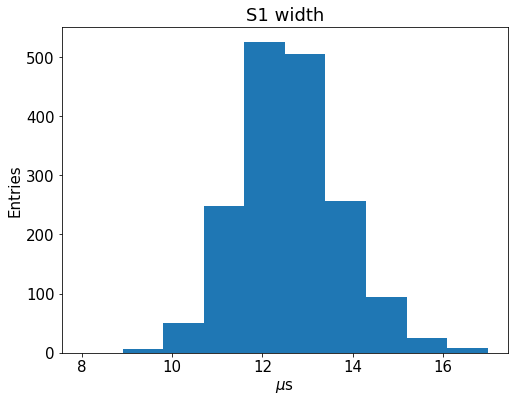

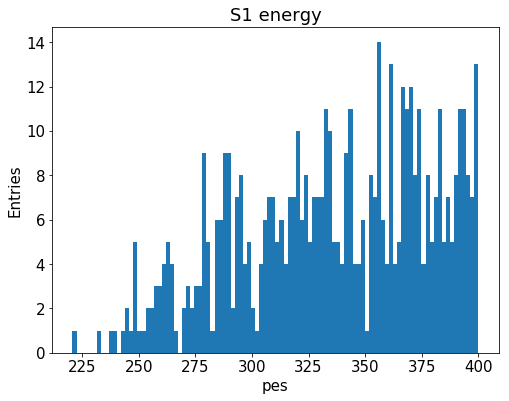

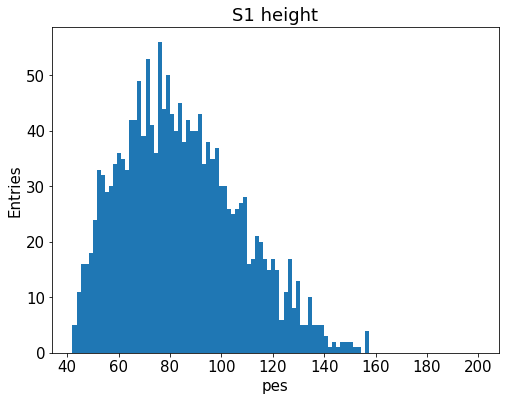

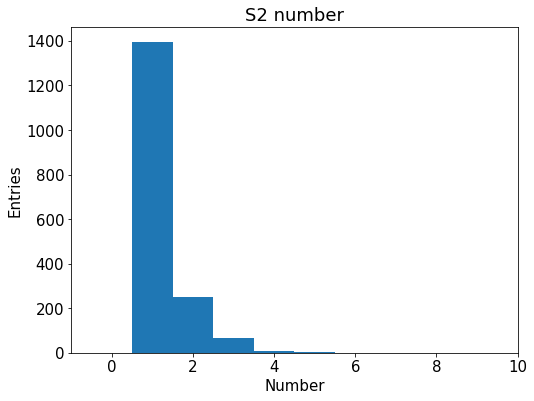

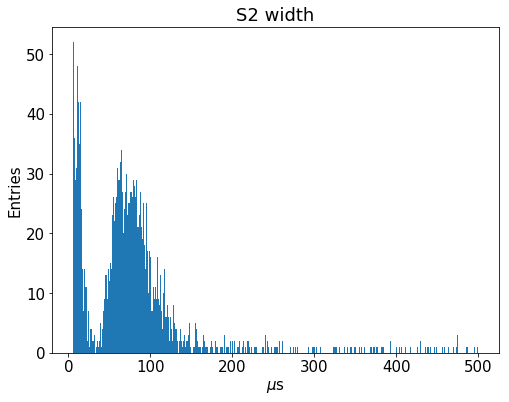

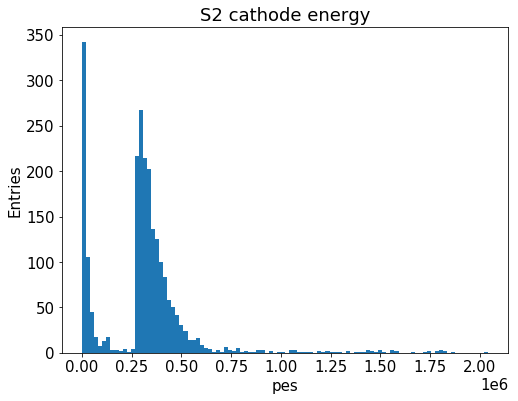

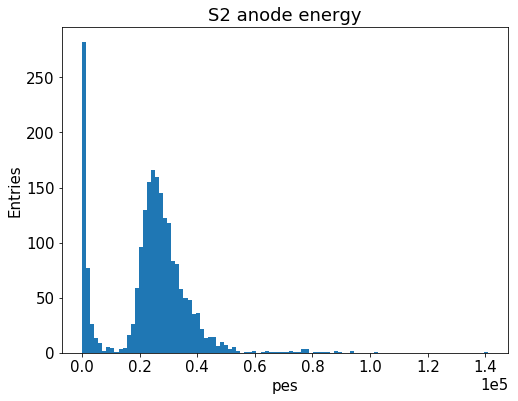

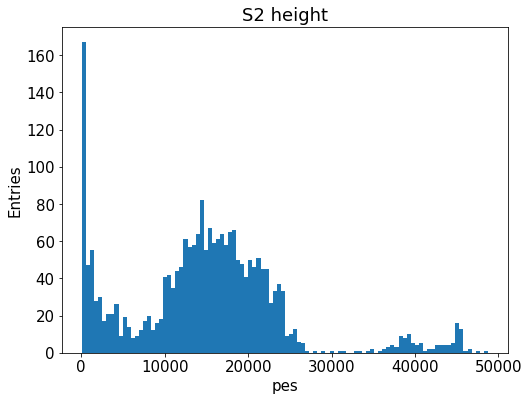

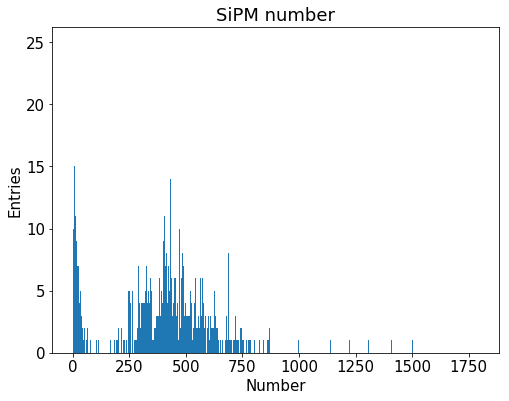

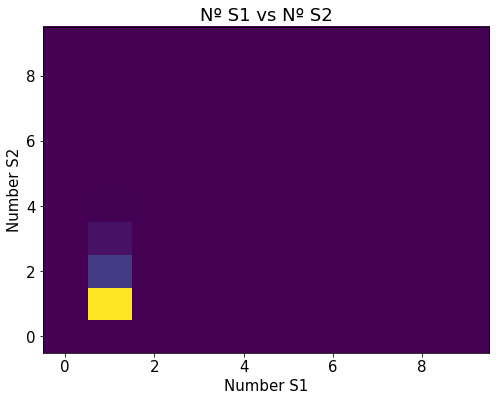

In [90]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = max_val["s1_emin"], s1_emax = max_val["s1_emax"], 
                                s1_ethr = max_val["s1_ethr"], s1_lmin = max_val["s1_wmin"], s1_lmax = max_val["s1_wmax"], 
                                s1_hmin = max_val["s1_hmin"], s1_hmax = max_val["s1_hmax"],
                                s2_nmin = s2_numMin, s2_nmax = s2_numMax, s2_emin = s2_emin, s2_emax = s2_emax, 
                                s2_lmin = s2_wmin, s2_lmax = s2_wmax, s2_hmin = s2_hmin, s2_hmax = s2_hmax, 
                                s2_nsipmmin = s2_nsipmmin, s2_nsipmmax = s2_nsipmmax, s2_ethr = s2_ethr)

n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)

print("S1 max args: {}".format(max_val))

print("Efficiency with S1 max args: {}".format(n_out/len(s1_all)))

plot_var(s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm)

## S2 cuts

### S2 min width

Maximum efficiency of 0.8788659793814433 at 0.0


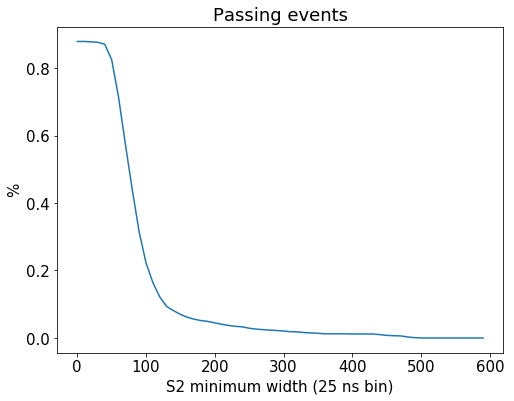

In [91]:
selector = refresh_selector()
var_min = 0.
var_max = 600.
step = 10.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Lmin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_wmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max width

Maximum efficiency of 0.8788659793814433 at 500.0


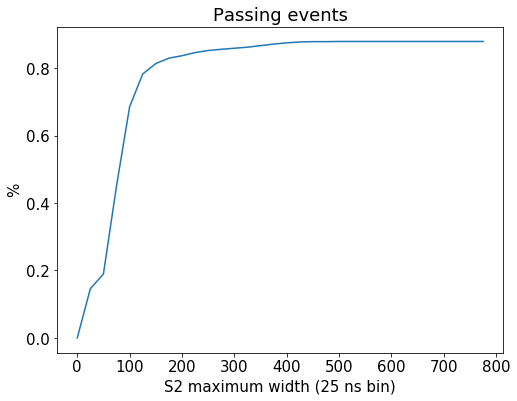

In [92]:
selector = refresh_selector()
var_min = 0.
var_max = 800.
step = 25.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Lmax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_wmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 min E

Maximum efficiency of 0.8788659793814433 at 0.0


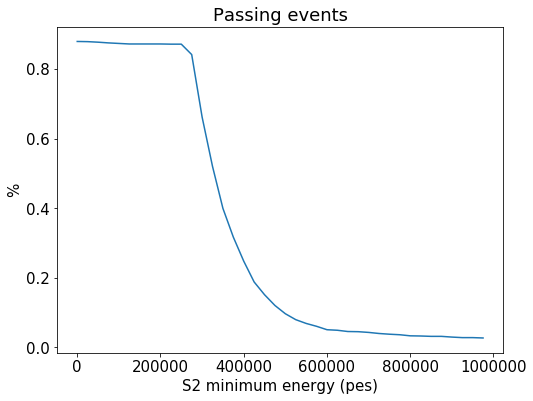

In [93]:
selector = refresh_selector()
var_min = 0
var_max = 1e6
step = 0.25e5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Emin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_emin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max E

Maximum efficiency of 0.8608247422680413 at 975000.0


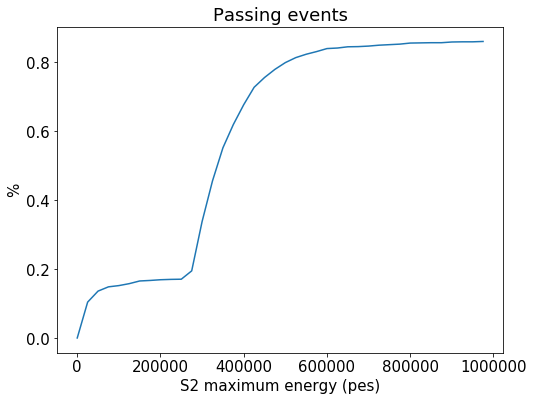

In [94]:
selector = refresh_selector()
var_min = 0
var_max = 1e6
step = 0.25e5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Emax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_emax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 min H

Maximum efficiency of 0.8788659793814433 at 0.0


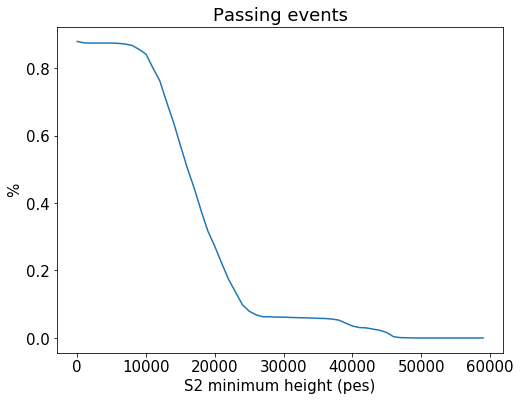

In [95]:
selector = refresh_selector()
var_min = 0.
var_max = 6e4
step = 1e3
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Hmin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_hmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max H

Maximum efficiency of 0.8788659793814433 at 49000.0


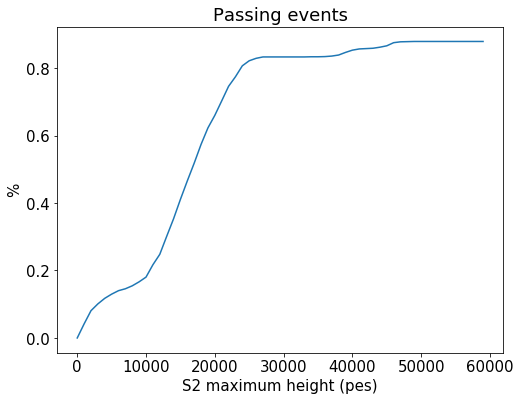

In [96]:
selector = refresh_selector()
var_min = 0.
var_max = 6e4
step = 1e3
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Hmax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_hmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 E thr

Maximum efficiency of 0.8788659793814433 at 0.0


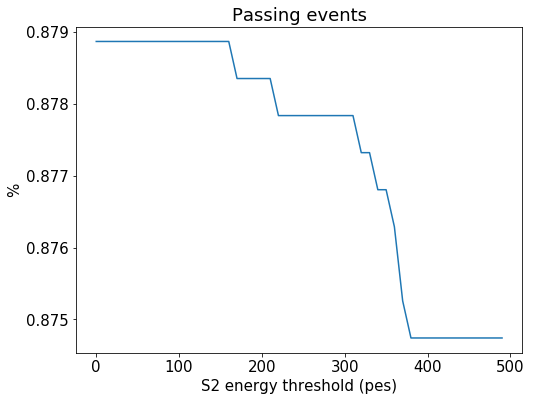

In [97]:
selector = refresh_selector()
var_min = 0.
var_max = 500.
step = 10.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Ethr = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 energy threshold (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_ethr"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 N SiPM min 

Maximum efficiency of 0.8788659793814433 at 0.0


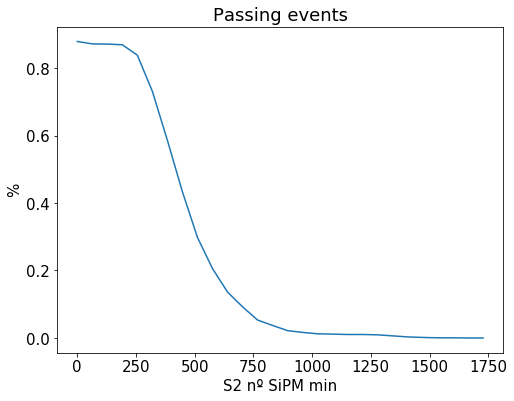

In [98]:
selector = refresh_selector()
var_min = 0.
var_max = 1792.
step = 64.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_NSIPMmin = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 nº SiPM min')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_nsipmmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 N SiPM max

Maximum efficiency of 0.8788659793814433 at 1536.0


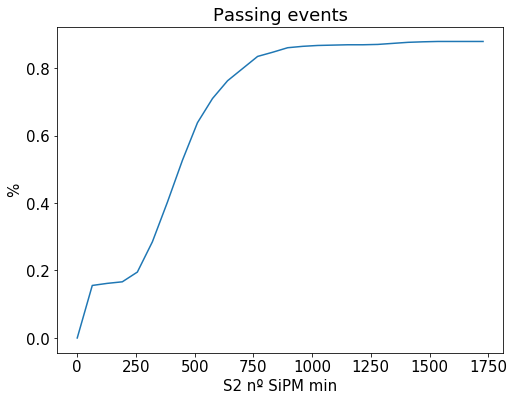

In [99]:
selector = refresh_selector()
var_min = 0.
var_max = 1792.
step = 64.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_NSIPMmax = w
    n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 nº SiPM min')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_nsipmmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### Efficiency with S2 max args

Max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0, 's2_wmin': 0.0, 's2_wmax': 500.0, 's2_emin': 0.0, 's2_emax': 975000.0, 's2_hmin': 0.0, 's2_hmax': 49000.0, 's2_ethr': 0.0, 's2_nsipmmin': 0.0, 's2_nsipmmax': 1536.0}
Efficiency with S2 max args: 0.8608247422680413


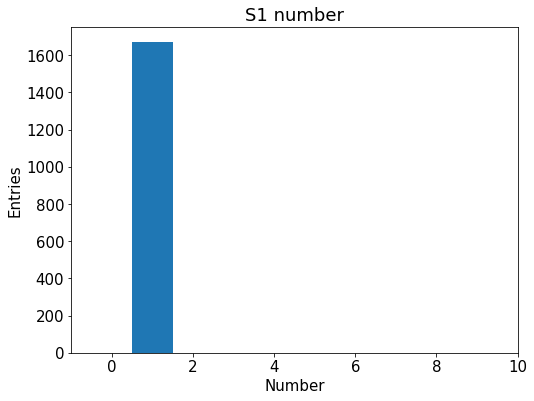

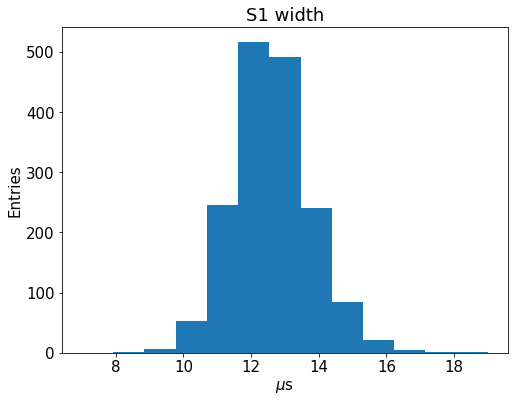

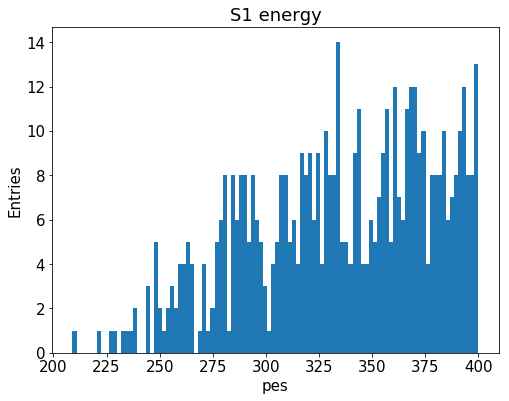

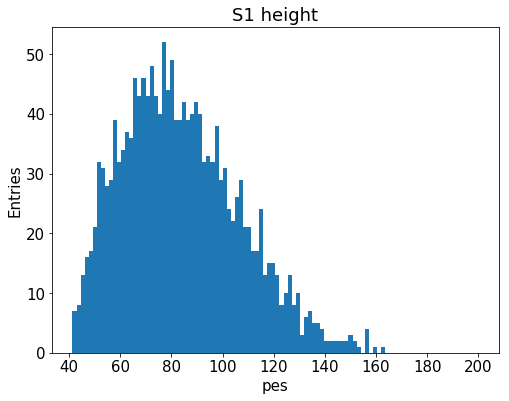

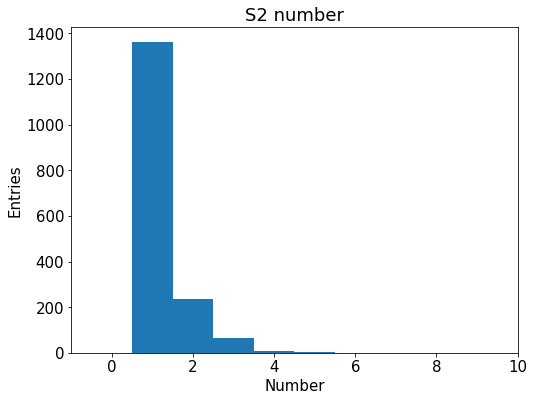

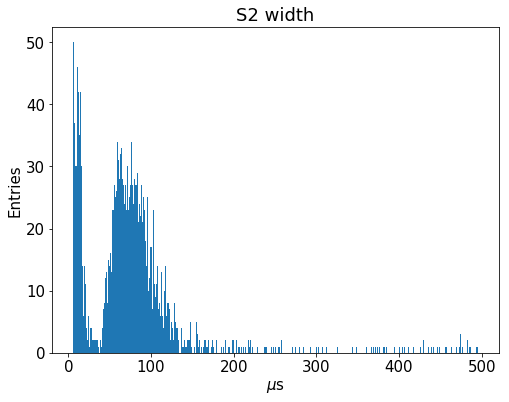

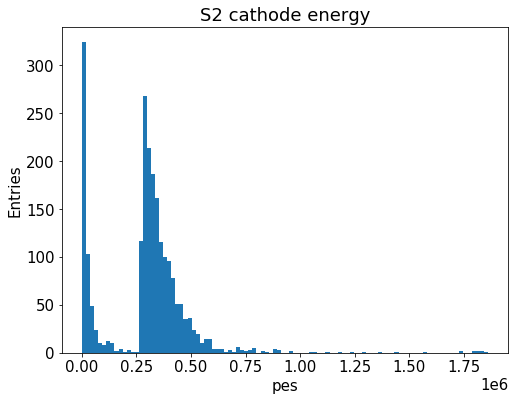

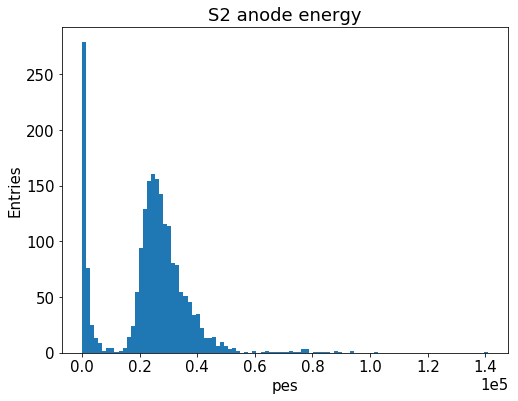

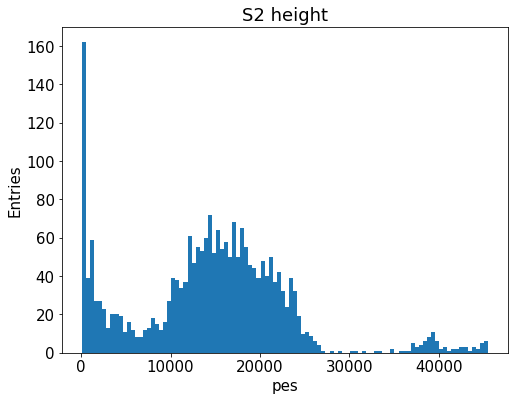

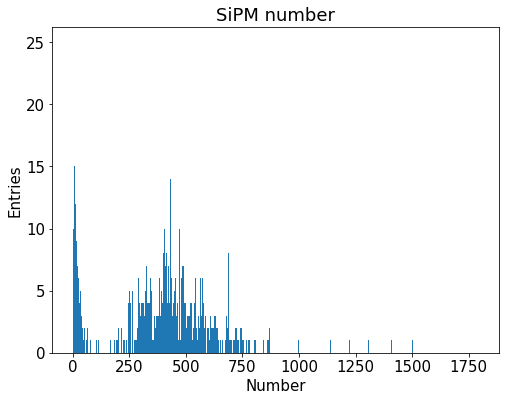

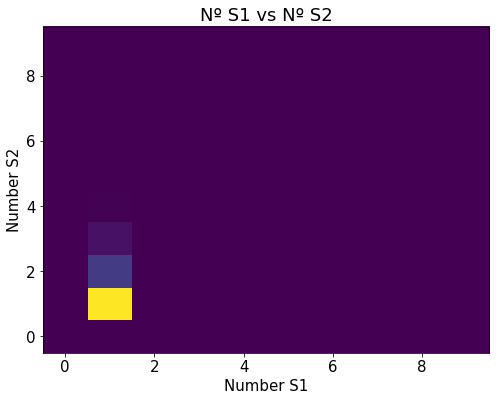

In [100]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = s1_emin, s1_emax = s1_emax, 
                                s1_ethr = s1_ethr, s1_lmin = s1_wmin, s1_lmax = s1_wmax, 
                                s1_hmin = s1_hmin, s1_hmax = s1_hmax,
                                s2_nmin = 1, s2_nmax = 10, s2_emin = max_val["s2_emin"], s2_emax = max_val["s2_emax"], 
                                s2_lmin = max_val["s2_wmin"], s2_lmax = max_val["s2_wmax"], s2_hmin = max_val["s2_hmin"],
                                s2_hmax = max_val["s2_hmax"], s2_nsipmmin = 1, 
                                s2_nsipmmax = 1800, s2_ethr = max_val["s2_ethr"])

n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)

print("Max args: {}".format(max_val))

print("Efficiency with S2 max args: {}".format(n_out/len(s1_all)))

plot_var(s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm)

### Efficiency with all max args

Max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0, 's2_wmin': 0.0, 's2_wmax': 500.0, 's2_emin': 0.0, 's2_emax': 975000.0, 's2_hmin': 0.0, 's2_hmax': 49000.0, 's2_ethr': 0.0, 's2_nsipmmin': 0.0, 's2_nsipmmax': 1536.0}
Efficiency with all max args: 0.8675257731958763


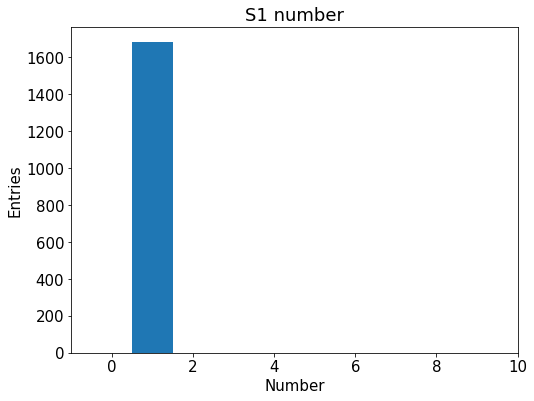

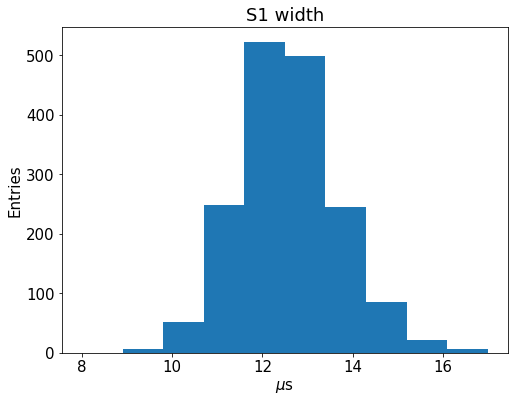

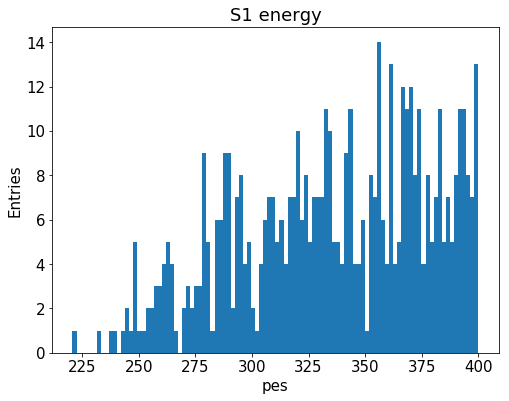

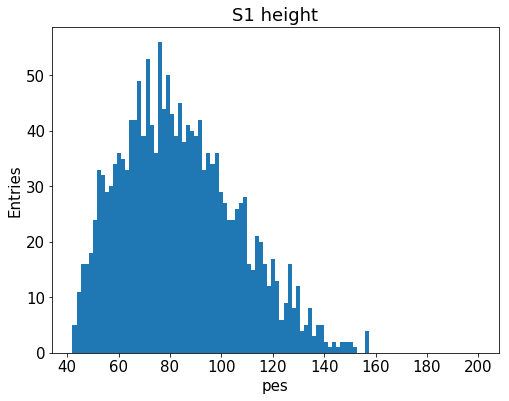

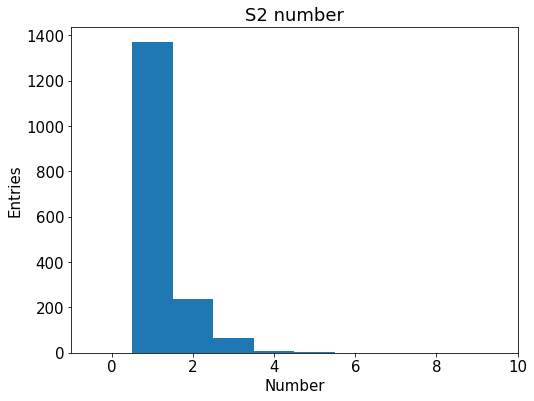

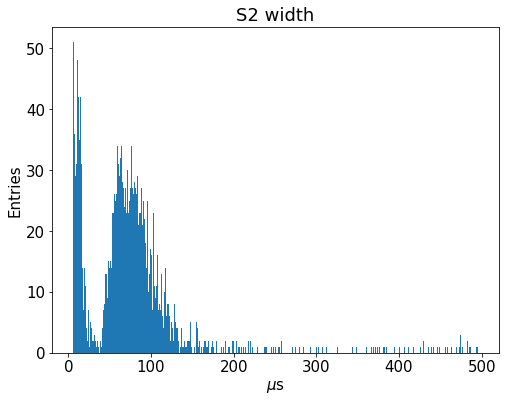

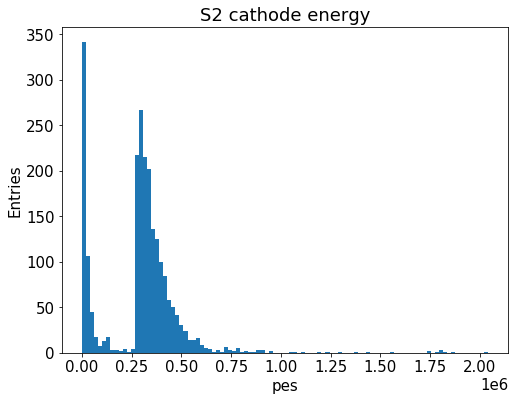

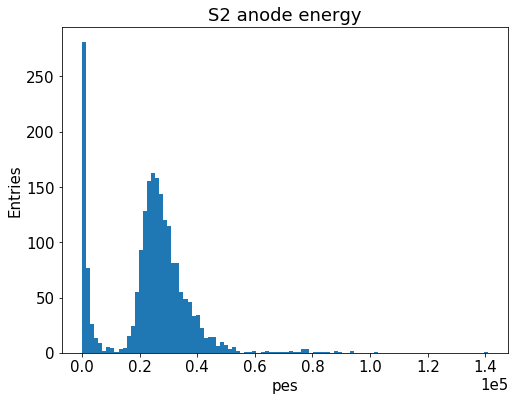

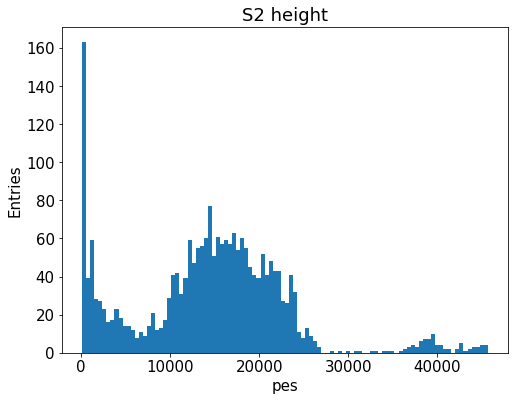

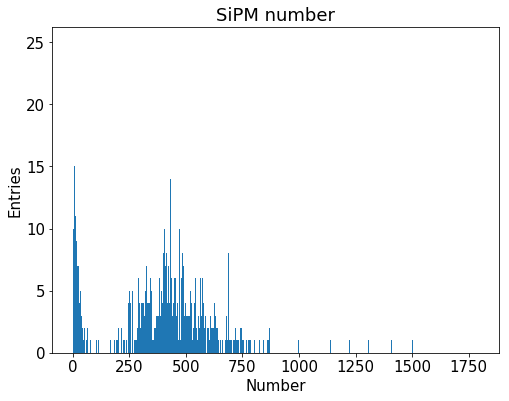

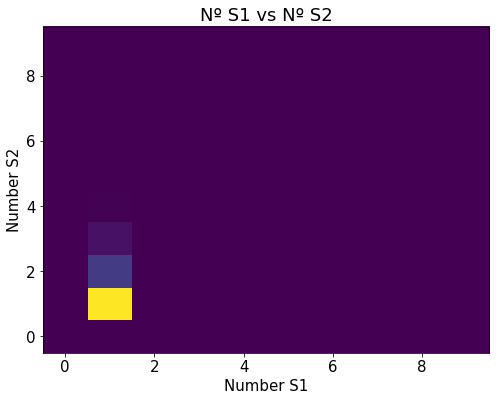

In [101]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = max_val["s1_emin"], s1_emax = max_val["s1_emax"], 
                                s1_ethr = max_val["s1_ethr"], s1_lmin = max_val["s1_wmin"], s1_lmax = max_val["s1_wmax"], 
                                s1_hmin = max_val["s1_hmin"], s1_hmax = max_val["s1_hmax"],
                                s2_nmin = 1, s2_nmax = 10, s2_emin = max_val["s2_emin"], s2_emax = max_val["s2_emax"], 
                                s2_lmin = max_val["s2_wmin"], s2_lmax = max_val["s2_wmax"], s2_hmin = max_val["s2_hmin"],
                                s2_hmax = max_val["s2_hmax"], s2_nsipmmin = 1, 
                                s2_nsipmmax = 1800, s2_ethr = max_val["s2_ethr"])

n_out, s1_cut, s2_cut, s2si_cut, s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm = select_peaks_dist(selector, s1_all, s2_all, s2si_all)

print("Max args: {}".format(max_val))

print("Efficiency with all max args: {}".format(n_out/len(s1_all)))

plot_var(s1n, s1w, s1h, s1e, s2n, s2w, s2h, s2ec, s2ea, s2nsipm)